In [245]:
!pip install scipy

# 0.0 IMPORTS

In [250]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display  import HTML
from IPython.display       import Image
from tabulate import tabulate
from scipy import stats as ss

## 0.1 Helper Functions

In [276]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v(x, y):
    # confusion matrix
    cm = pd.crosstab(x, y).to_numpy()
    # sum confunsion matrix values
    n = cm.sum()
    # rows and cols
    r, k = cm.shape
    # chi2
    chi2 = ss.chi2_contingency(cm)[0]
    # chi2 correction
    chi2corr = max(0 , chi2 - (k - 1) * (r - 1) / (n - 1))
    # k correction
    kcorr = k - (k-1)**2 / (n - 1)
    # r correction
    rcorr = r - (r-1)**2 / (n - 1) 
    # v_cramer
    return np.sqrt( (chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

In [121]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [122]:
# loading datasets

df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merging datasets

df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# 1.0 DATA DESCRIPTION

In [123]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [124]:
# original name of the columns

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

# using inflection to create the new cols

snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case, cols_old))

# renaming the cols

df1.columns = cols_new

## 1.2 - Data Dimension

In [125]:
# dataset's size

print(f'Number of rows:\t\t {df1.shape[0]}')
print(f'Number of columns:\t {df1.shape[1]}')

Number of rows:		 1017209
Number of columns:	 18


## 1.3 - Data Types

In [126]:
# transforming date to datetime

df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check NAs

In [127]:
df1.isna().sum().sort_values()

store                                0
promo2                               0
assortment                           0
store_type                           0
state_holiday                        0
promo                                0
school_holiday                       0
customers                            0
sales                                0
date                                 0
day_of_week                          0
open                                 0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2_since_year               508031
promo2_since_week               508031
promo_interval                  508031
dtype: int64

## 1.5 Fill Out NAs

In [128]:
# competition_distance

max_value = df1['competition_distance'].max()

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: max_value * 2 if math.isnan(x) else x)

# competition_open_since_month

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# competition_open_since_year 

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

# promo2_since_week  

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# promo2_since_year

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# promo_interval           

month_map = {1:'Jan',
             2:'Feb',
             3:'Mar',
             4:'Apr',
             5:'Mai',
             6:'Jun',
             7:'Jul',
             8:'Aug',
             9:'Sep',
             10:'Oct',
             11:'Nov',
             12:'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [129]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [130]:
# changing the variable type from float to int

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistics

Serve para duas coisas: 1 ganhar conhecimento de negocios, e a segunda é para a detecção de alguns erros. Existem duas grandes métricas. Disperção e tendencia central. 

Tendencia Central resumem os dados em um único número, exemplo média, mediana e etc.
As medidas de disperção irão nos mostram o quão exparso os dados estão dessas medidas, para mnostrar o quão distante ou proximo os dados estão das medias.

skew fala a deformação da distribuição normal, esquerda positiva, direita negativa

kurtosi quanto maior a curtosi a pico é alto, menor o pico curtosi negativa e dados dispersos.

In [131]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [132]:
num_att = df1.select_dtypes(include = ['int32', 'int64', 'float64'])

cat_att = df1.select_dtypes(exclude = ['int32', 'int64', 'float64', 'datetime64[ns]'])

### 1.7.1 - Nummerical Attributes

In [133]:
# central tendency - mean, median

ct1 = pd.DataFrame(num_att.apply(np.mean)).T

ct2 = pd.DataFrame(num_att.apply(np.median)).T

# dispersion - standard deviation, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_att.apply(np.std)).T

d2 = pd.DataFrame(num_att.apply(min)).T

d3 = pd.DataFrame(num_att.apply(max)).T

d4 = pd.DataFrame(num_att.apply(lambda x: x.max() - x.min())).T

d5 = pd.DataFrame(num_att.apply(lambda x: x.skew())).T

d6 = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).T

# concatenate

m = pd.concat((d2, d3, d4, ct1, ct2, d1, d5, d6)).T.reset_index()

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,151720.0,151700.0,5810.044888,2330.0,10715.007635,7.593832,90.447876
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [134]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,151720.0,151700.0,5810.044888,2330.0,10715.007635,7.593832,90.447876
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


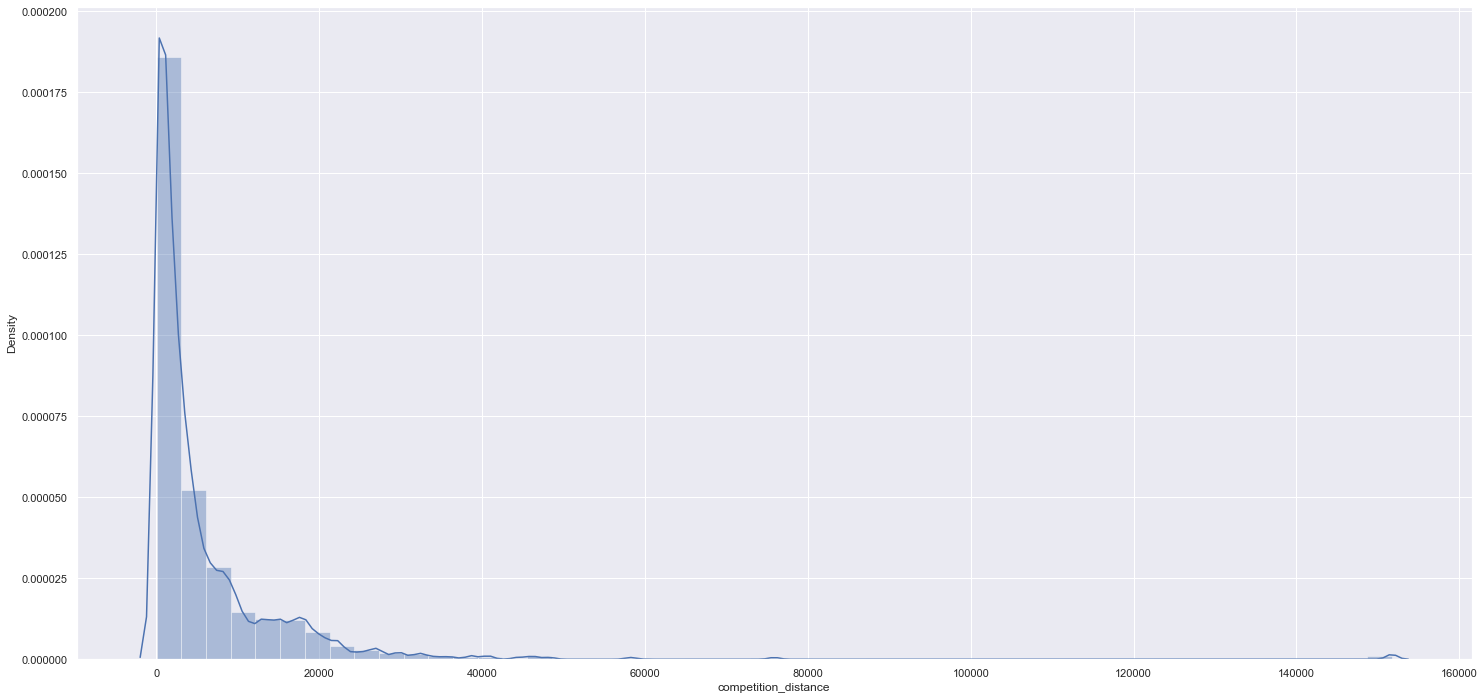

In [135]:
sns.distplot(df1['competition_distance']);

### 1.7.2 - Categorical Attributes

In [136]:
cat_att.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

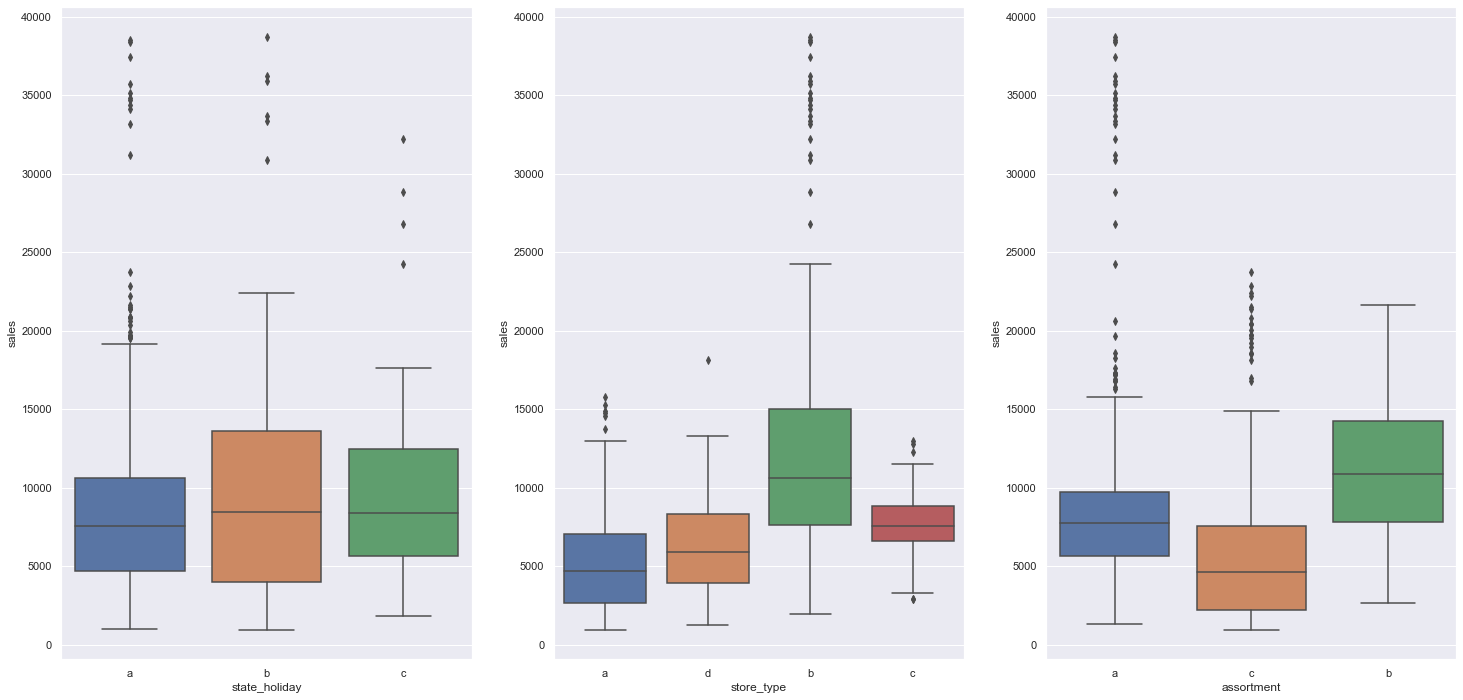

In [137]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)
plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)
plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1);

# 2.0 FEATURE ENGINEERING

In [138]:
df2 = df1.copy()

## 2.1 Mindmap Hyphotesis

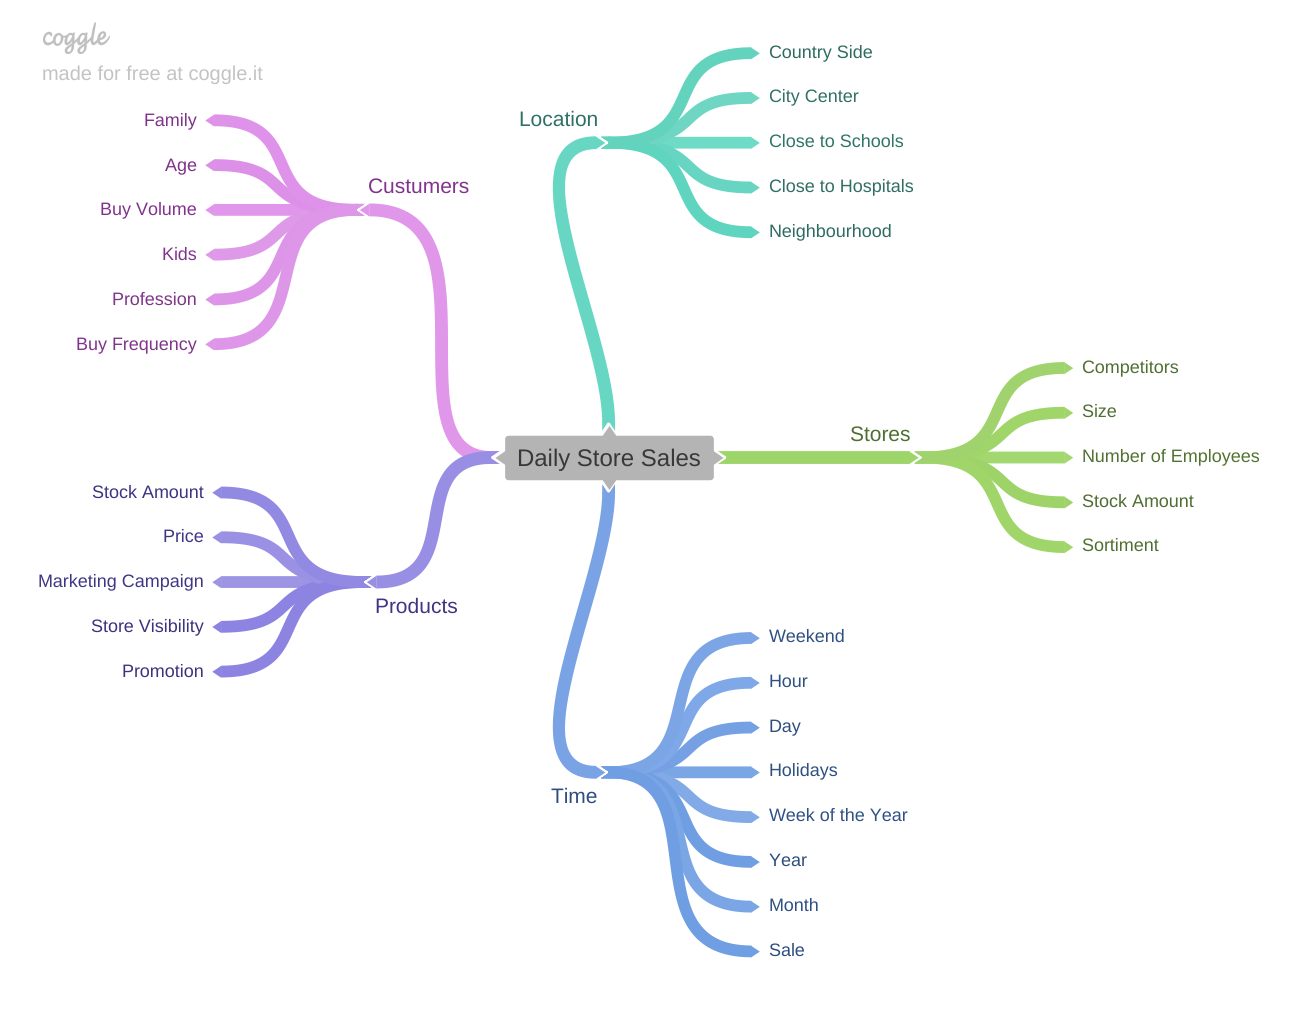

In [139]:
Image('img/mental_map.png')

## 2.2 Hyphotesis Creation

### 2.2.1 - Store's Hypothesis

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2 - Products's Hypothesis

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição de produtos deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 - Time's Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Final List of Hyphotesis

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4 Feature Engineering

In [140]:
# year

df2['year'] = df2['date'].dt.year

# month

df2['month'] = df2['date'].dt.month

# day

df2['day'] = df2['date'].dt.day

# week_of_year

df2['week_of_year'] = df2['date'].dt.weekofyear

# year_week

df2['week_of_year'] = df2['date'].dt.strftime('%Y-%W')

# competition_since

df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo_since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state_holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [141]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 FEATURE FILTERING

In [142]:
df3 = df2.copy()

In [143]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Rows Filtering

In [144]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.1 Cols Selection

In [145]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis = 1)

df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'competition_since', 'competition_time_month',
       'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Exploratory Data Analysis

In [146]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

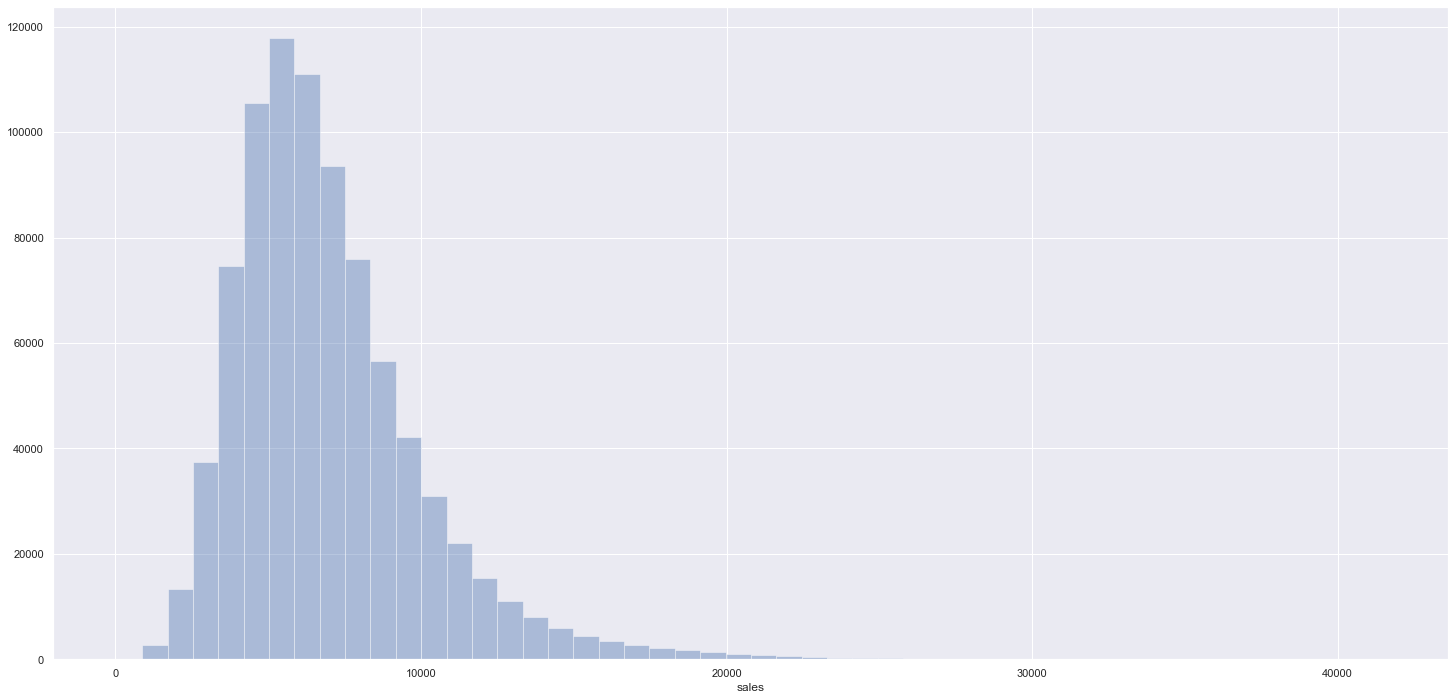

In [147]:
sns.distplot(df4['sales'], kde = False);

### 4.1.2 Numerical Variables

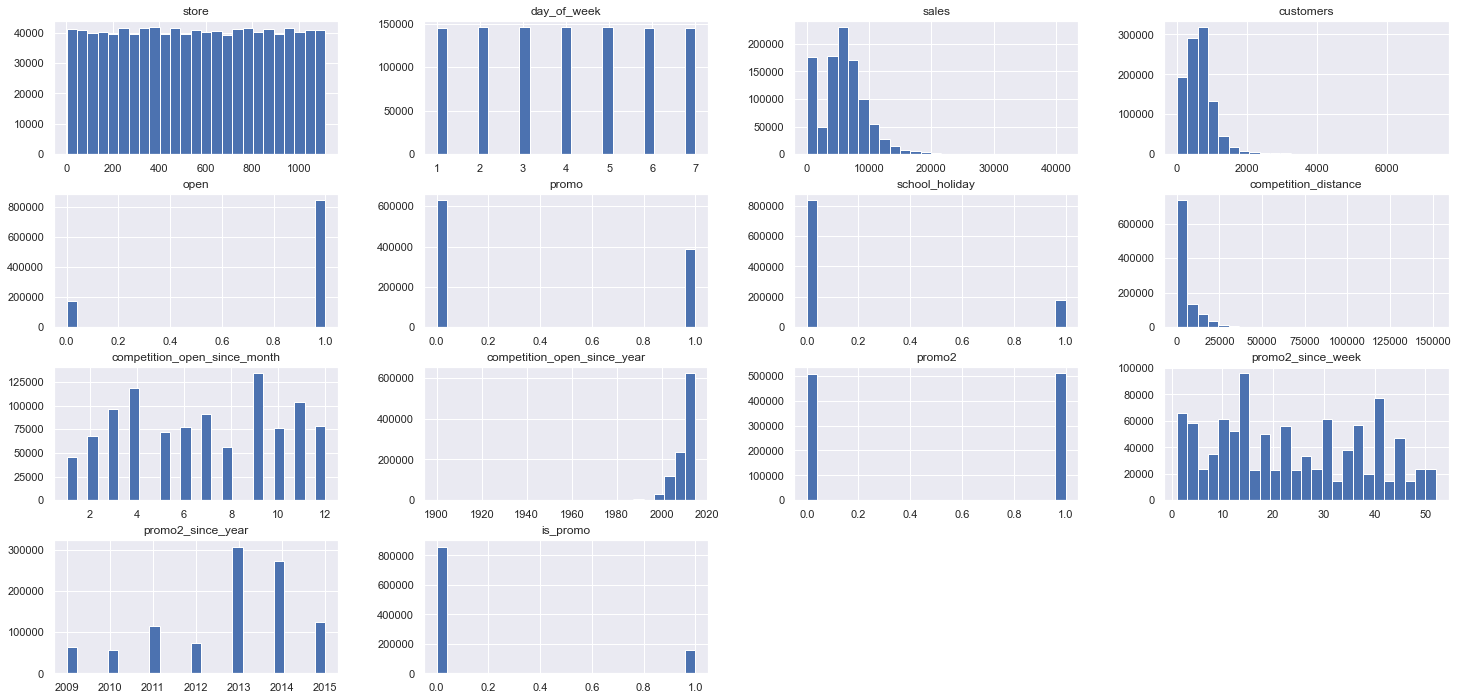

In [148]:
num_att.hist(bins = 25);

### 4.1.3 Categorical Variables

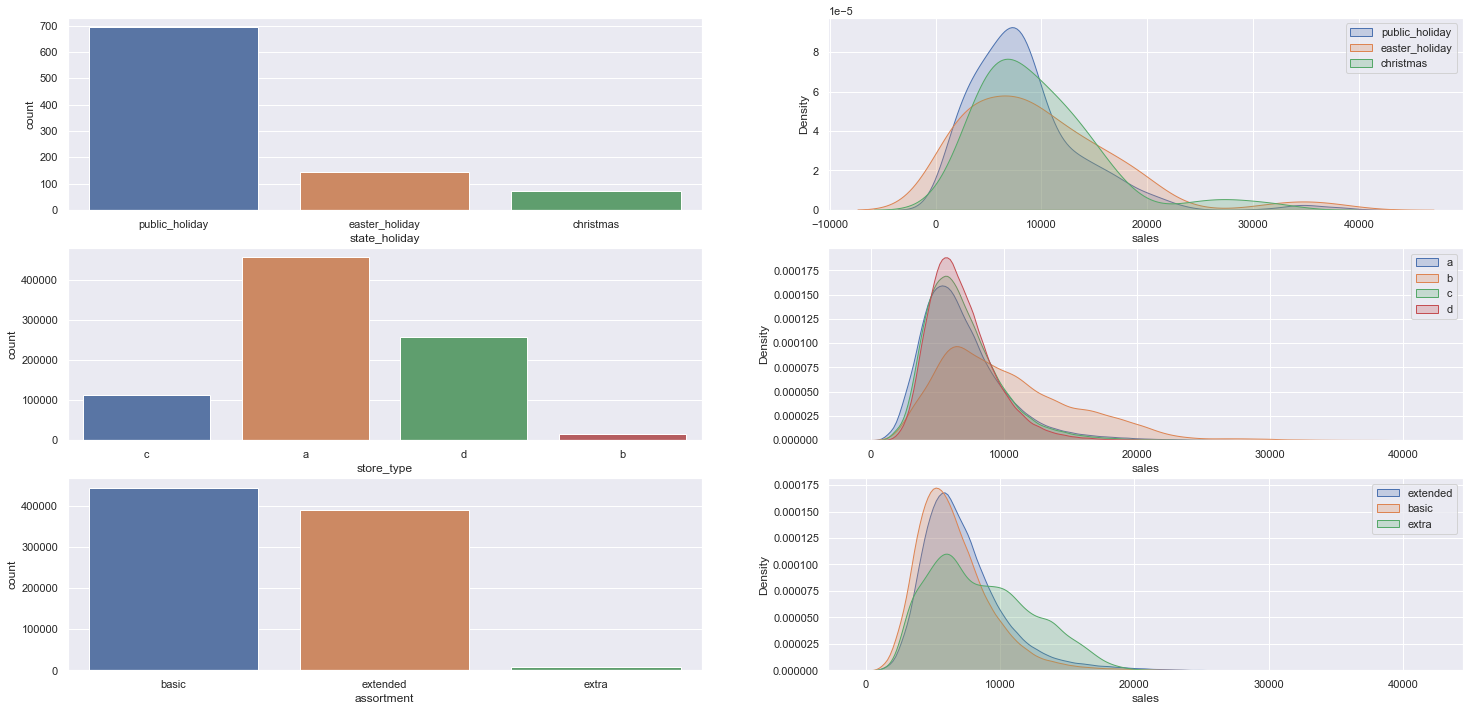

In [176]:
# state_holiday

plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], shade = True, label ='public_holiday' )
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade = True, label ='easter_holiday' )
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], shade = True, label ='christmas' )
plt.legend()

# store_type

plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], shade = True, label = 'a')
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], shade = True, label = 'b')
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], shade = True, label = 'c')
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], shade = True, label = 'd')
plt.legend()

# assortment

plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], shade = True, label = 'extended')
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], shade = True, label = 'basic')
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], shade = True, label = 'extra')
plt.legend();

## 4.2 Bivariate Analysis

### H1. Lojas com maior sortimento deveriam vender mais.
**FALSE** - Lojas com maior sortimento vendem menos

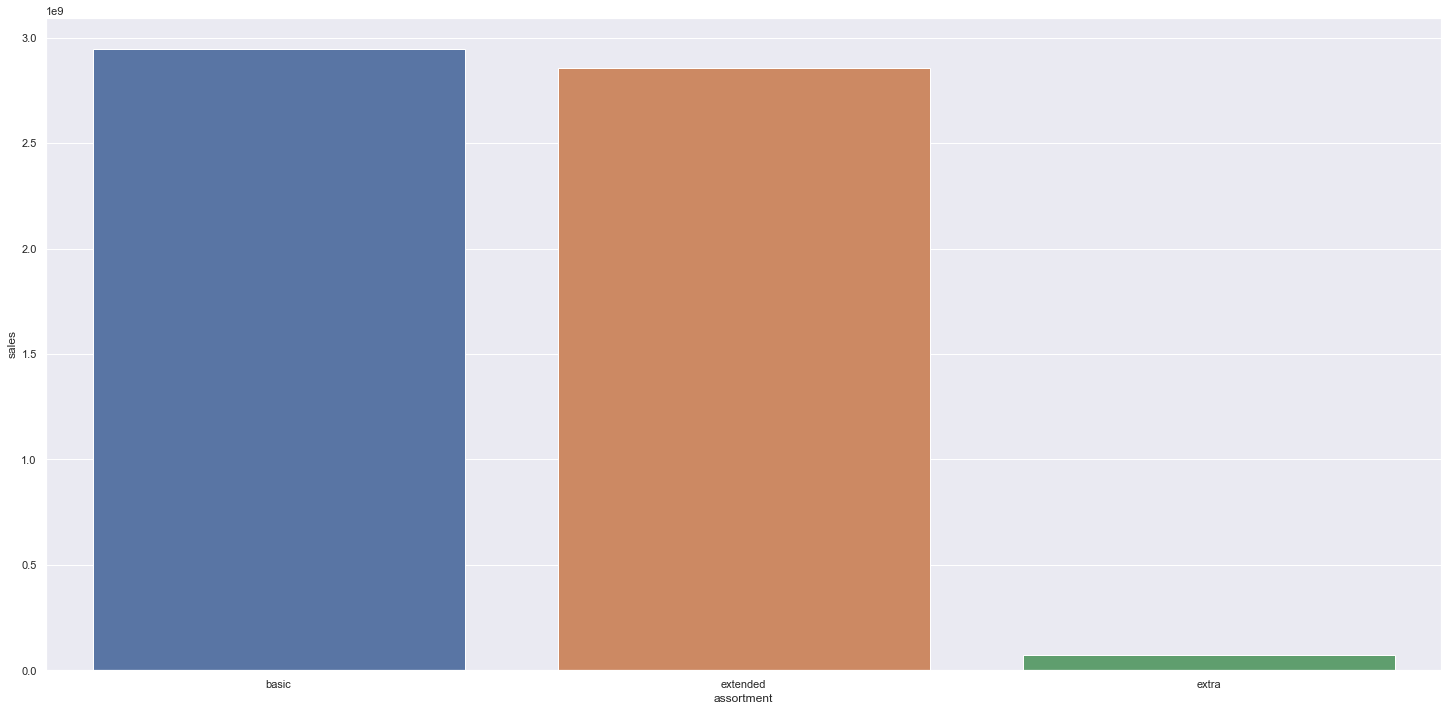

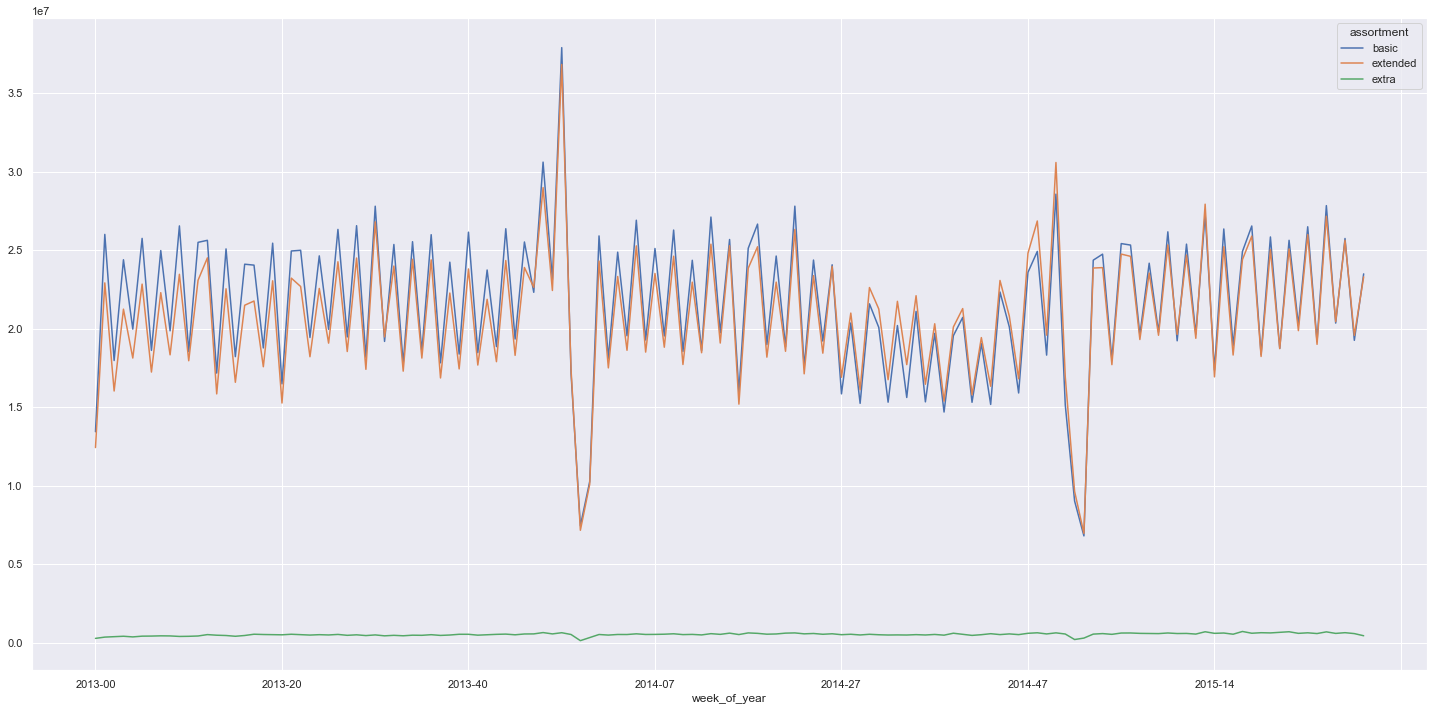

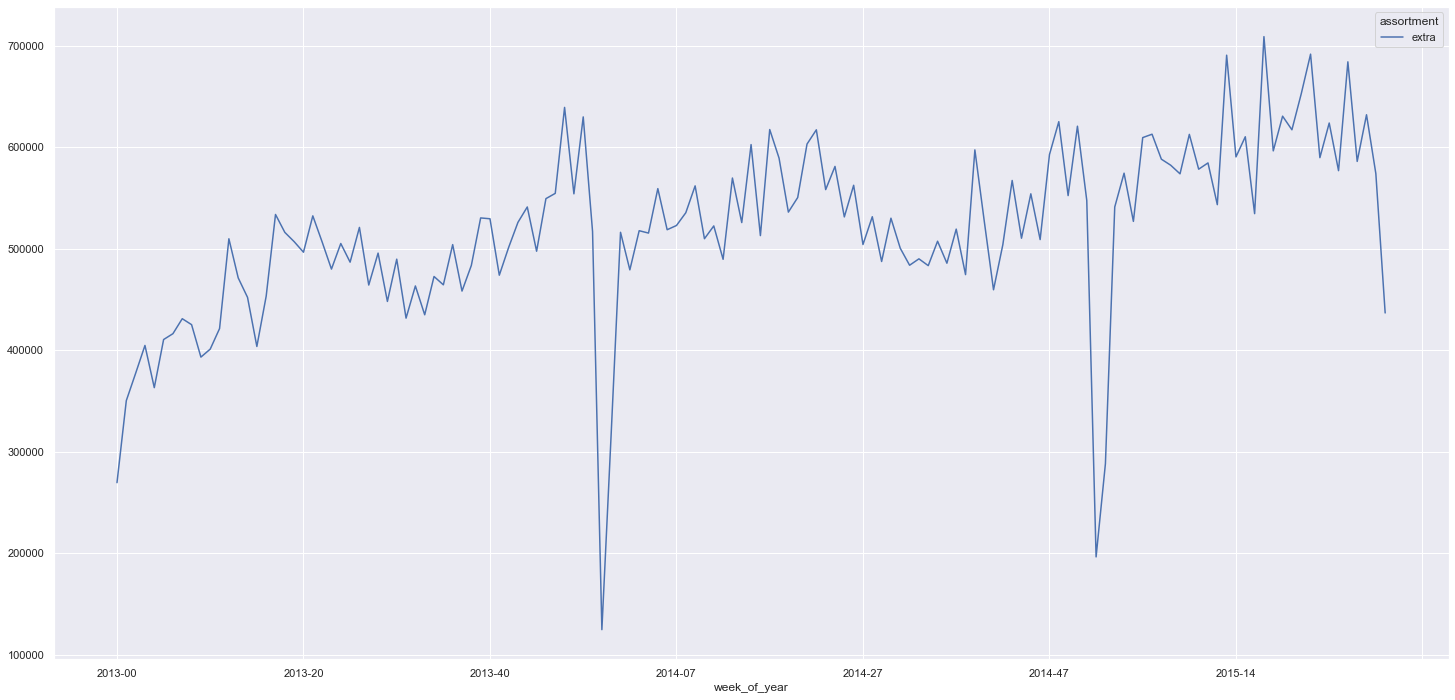

In [185]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

aux2 = df4[['week_of_year', 'assortment', 'sales']].groupby(['week_of_year','assortment']).sum().reset_index()
aux2.pivot(index = 'week_of_year', columns = 'assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'week_of_year', columns = 'assortment', values = 'sales').plot();

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSE** - Lojas com competidores mais próximos vendem mais.

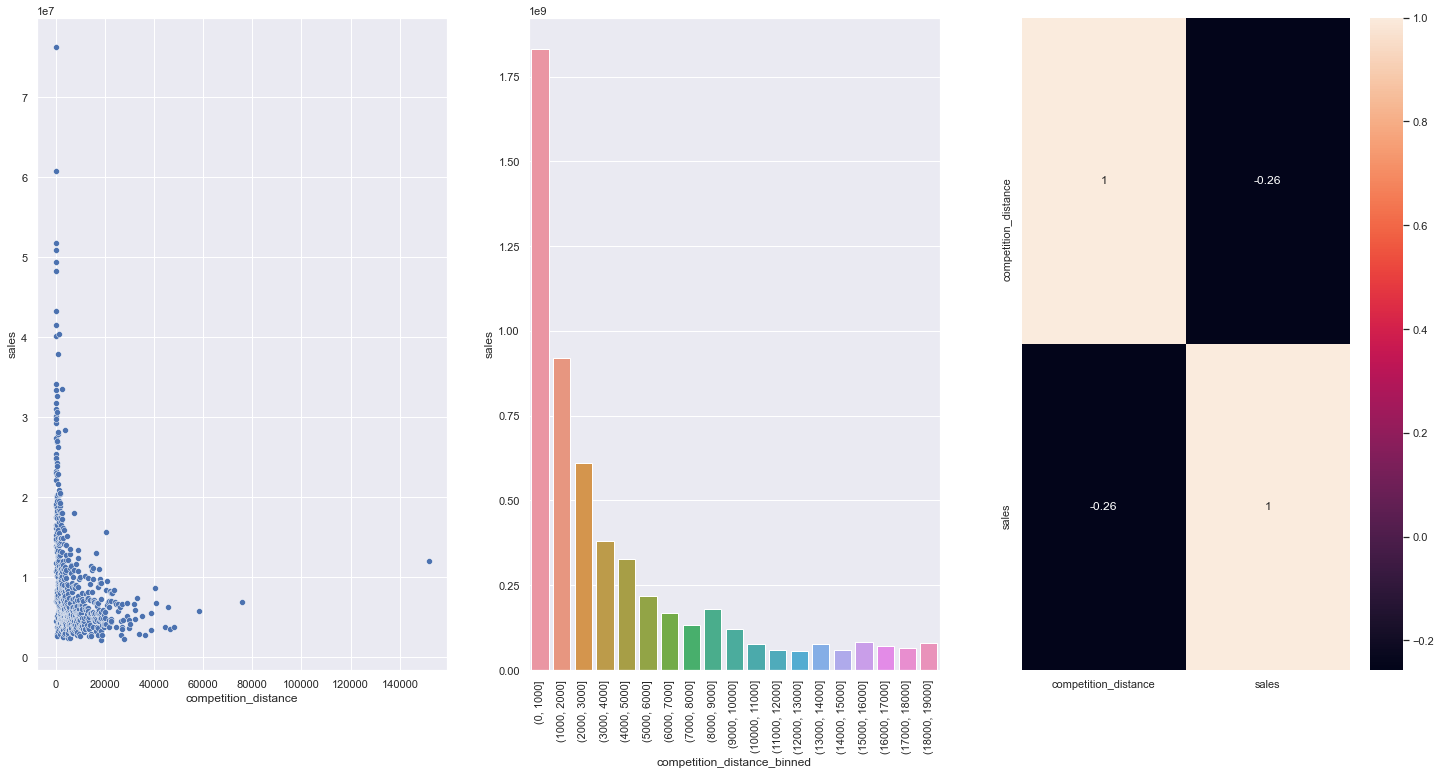

In [201]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2)
plt.xticks(rotation = 90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);


### H3. Lojas com competidores a mais tempo deveriam vender mais.
**FALSE** - Lojas com competidores a mais tempo vendem menos.

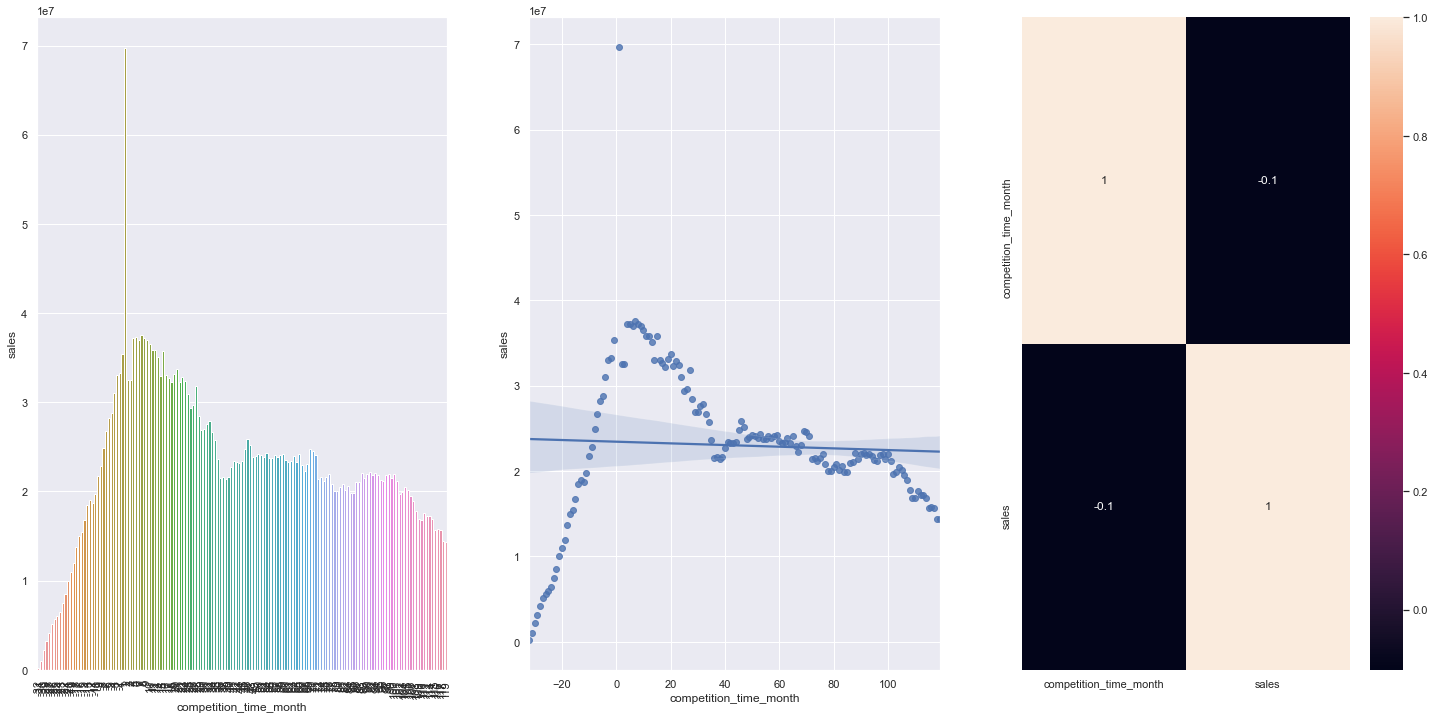

In [210]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1, 3, 2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSE** - Lojas com promoções ativas por mais tempo vendem menos depois de um certo período de promoção.

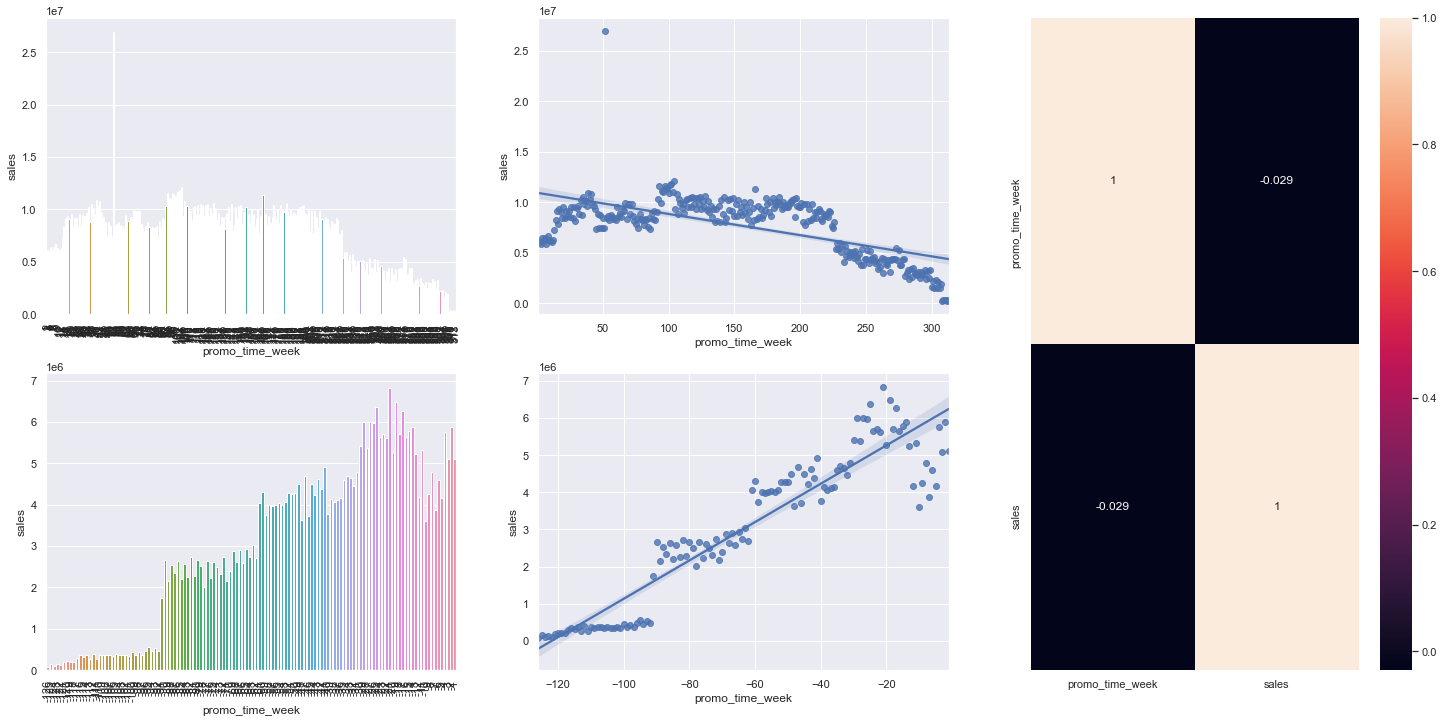

In [216]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2)
plt.xticks(rotation = 90)

plt.subplot(grid[0, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2)

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3)
plt.xticks(rotation = 90)

plt.subplot(grid[1, 1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3)

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSE** - Lojas com mais promoções consecutivas vendem menos.

In [217]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


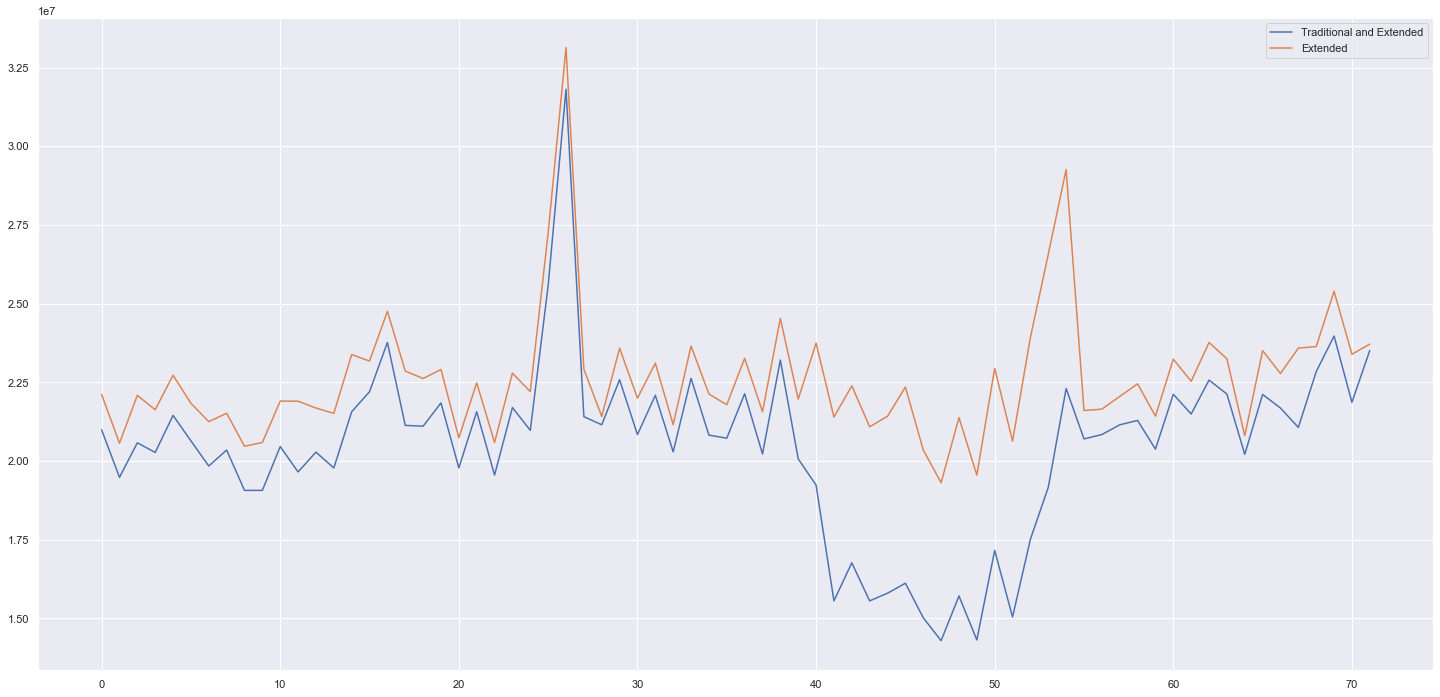

In [222]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['week_of_year', 'sales']].groupby('week_of_year').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['week_of_year', 'sales']].groupby('week_of_year').sum().reset_index()
aux2.plot(ax = ax)

ax.legend(labels = ['Traditional and Extended', 'Extended']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSE** - Lojas abertas durante o feriado de Natal vendem menos.

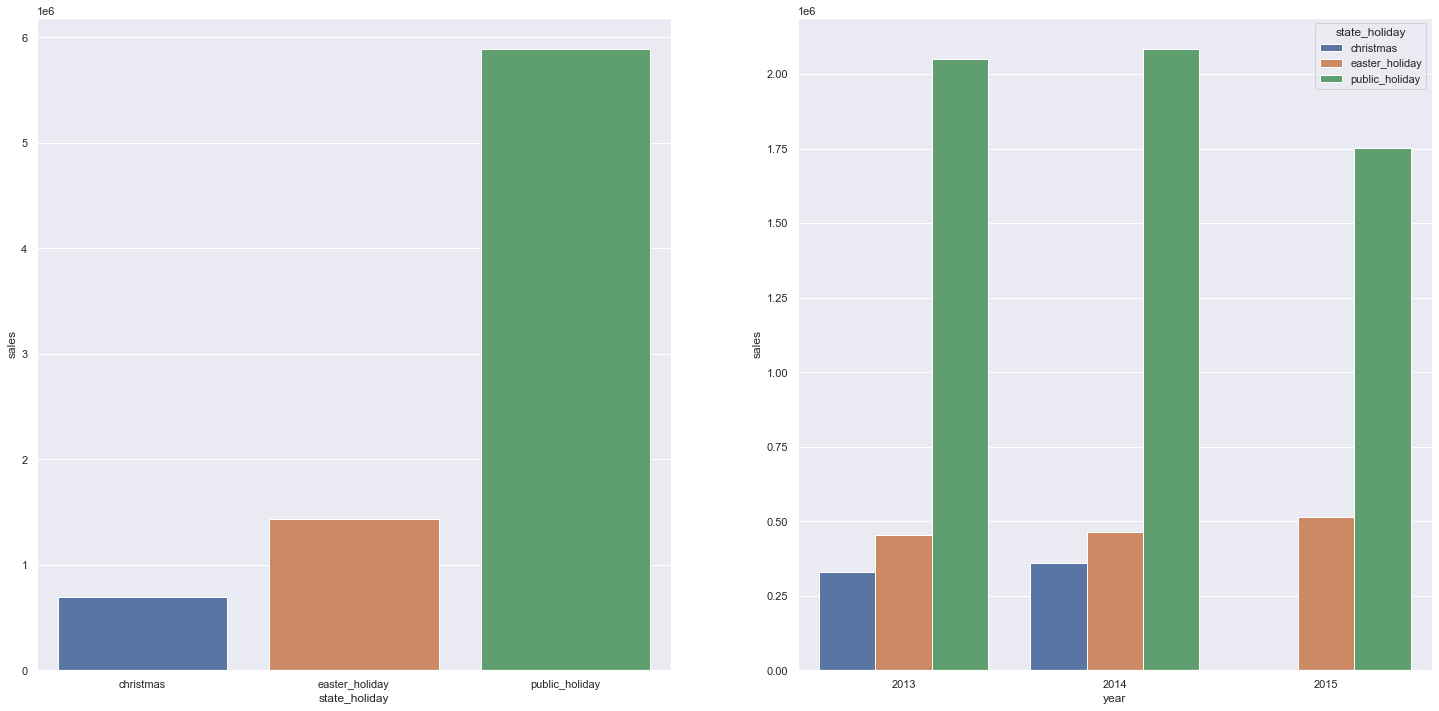

In [227]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);

### H8 Lojas deveriam vender mais ao longo dos anos.
**FALSE** - Lojas vendem menos ao longo dos anos.

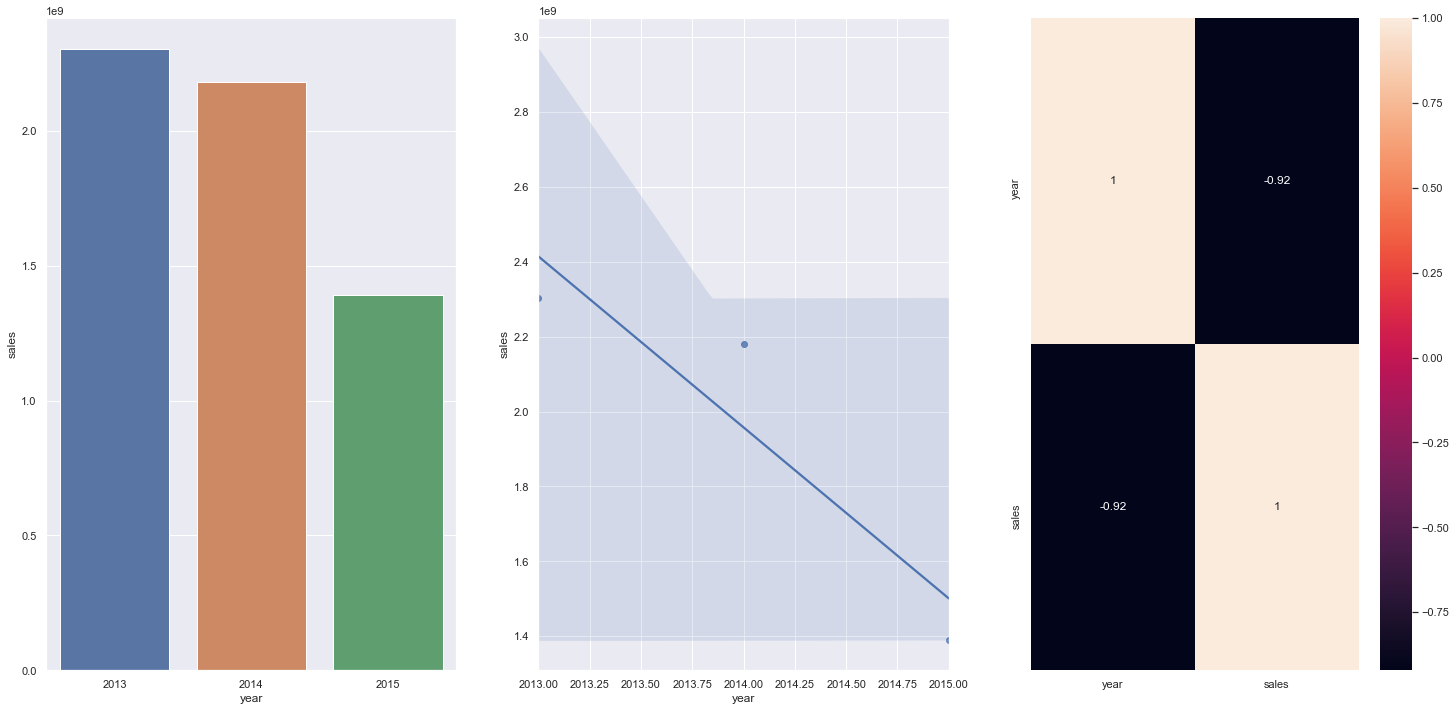

In [229]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'year', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'year', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H9 Lojas deveriam vender mais no segundo semestre do ano.
**FALSE** - Lojas vendem menos no segundo semestre do ano.

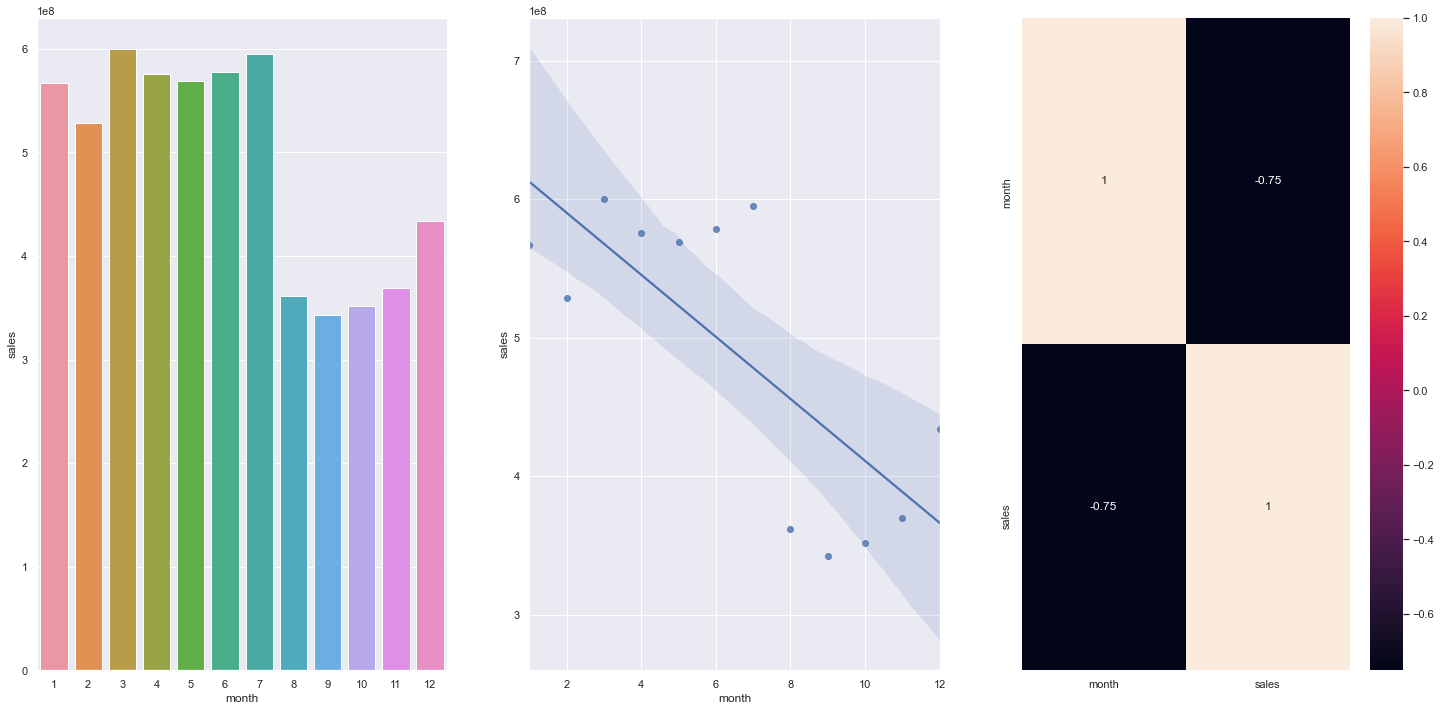

In [230]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'month', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H10 Lojas deveriam vender mais depois do dia 10 de cada mês.
**TRUE** - Lojas vendem mais depois do dia 10 de cada mês.

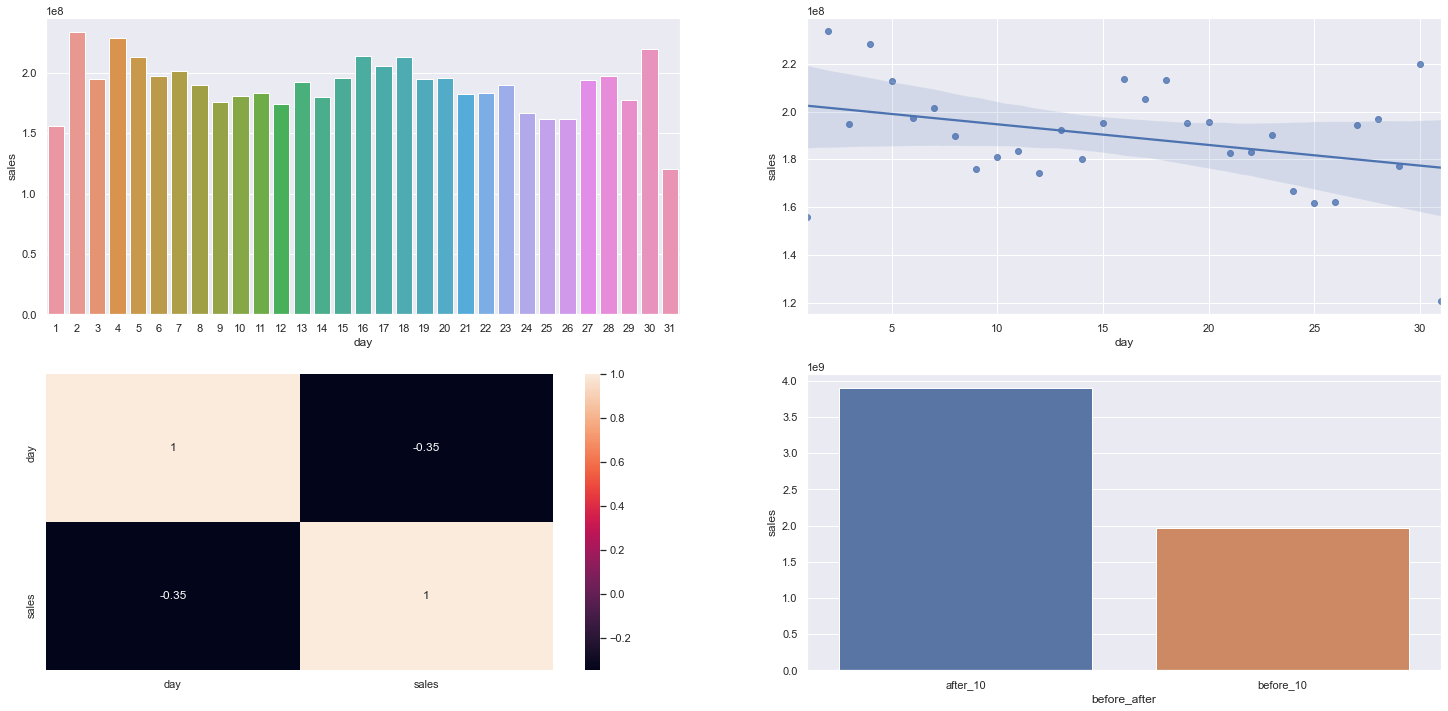

In [233]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2, 2, 2)
sns.regplot(x = 'day', y = 'sales', data = aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10' if x <= 10 else 'after_10')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = aux2);

### H11 Lojas deveriam vender menos aos finais de semana.
**TRUE** - Lojas vendem menos aos finais de semana.

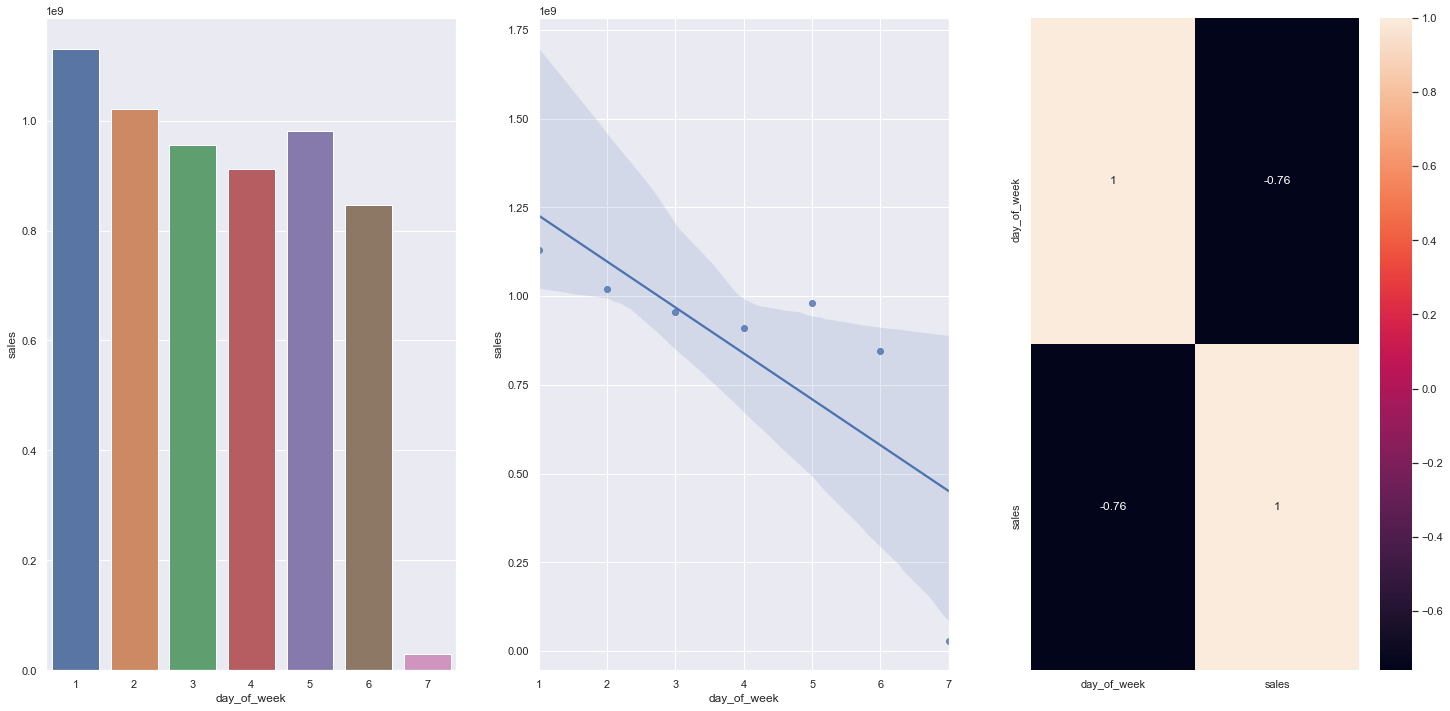

In [235]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1, 3, 2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H12 Lojas deveriam vender menos durante os feriados escolares.
**TRUE** - Lojas vendem menos durante os feriados escolares, exceto nos meses de julho e agosto.

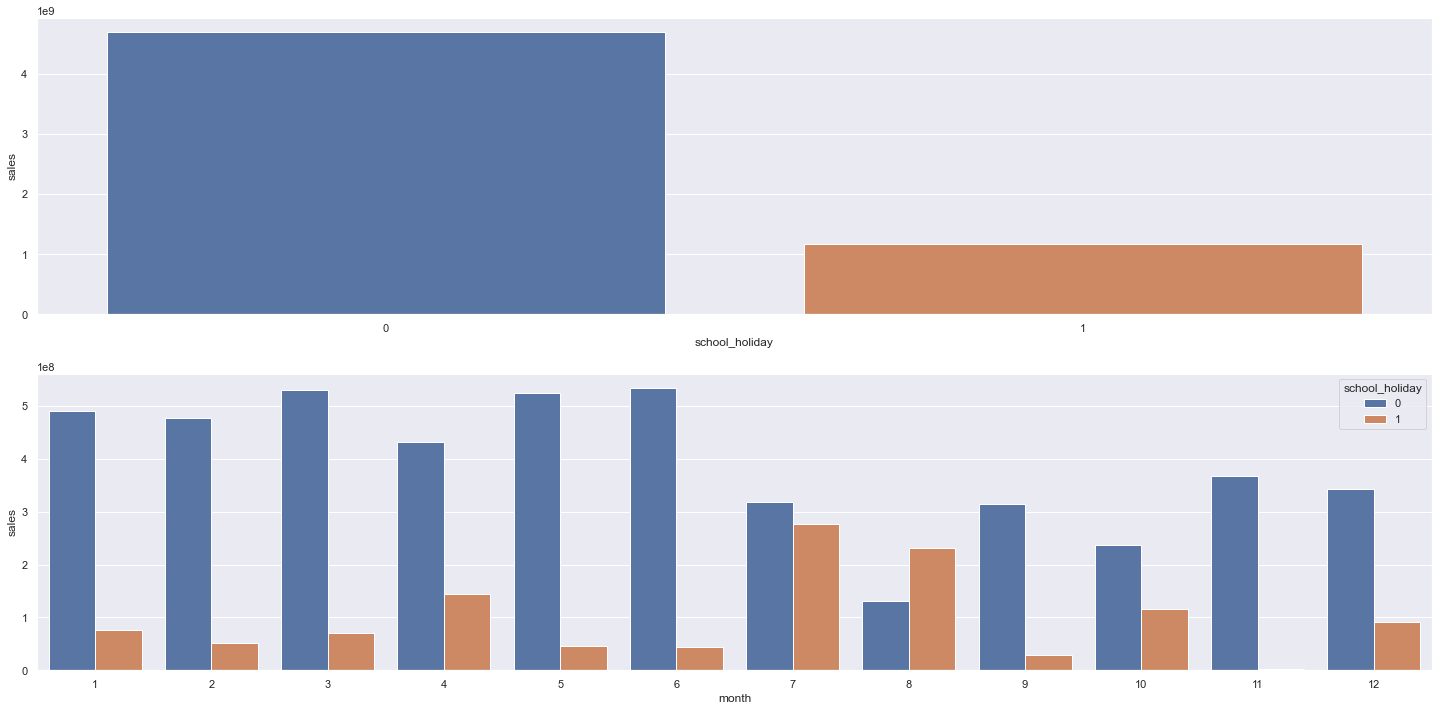

In [238]:
plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

### 4.2.1 Hypothesis' Summary

In [242]:
tab = [['Hypothesis', 'Conclusion', 'Relevance'],
       ['H1', 'FALSE', 'Low'],
       ['H2', 'FALSE', 'Medium'],
       ['H3', 'FALSE', 'Medium'],
       ['H4', 'FALSE', 'Low'],
       ['H5', '-', '-'],
       ['H6', 'FALSE', 'Low'],
       ['H7', 'FALSE', 'Medium'],
       ['H8', 'FALSE', 'High'],
       ['H9', 'FALSE', 'High'],
       ['H10', 'TRUE', 'High'],
       ['H11', 'TRUE', 'High'],
       ['H12', 'TRUE', 'Low'],
      ]

print(tabulate(tab, headers = 'firstrow'))

Hypothesis    Conclusion    Relevance
------------  ------------  -----------
H1            FALSE         Low
H2            FALSE         Medium
H3            FALSE         Medium
H4            FALSE         Low
H5            -             -
H6            FALSE         Low
H7            FALSE         Medium
H8            FALSE         High
H9            FALSE         High
H10           TRUE          High
H11           TRUE          High
H12           TRUE          Low


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

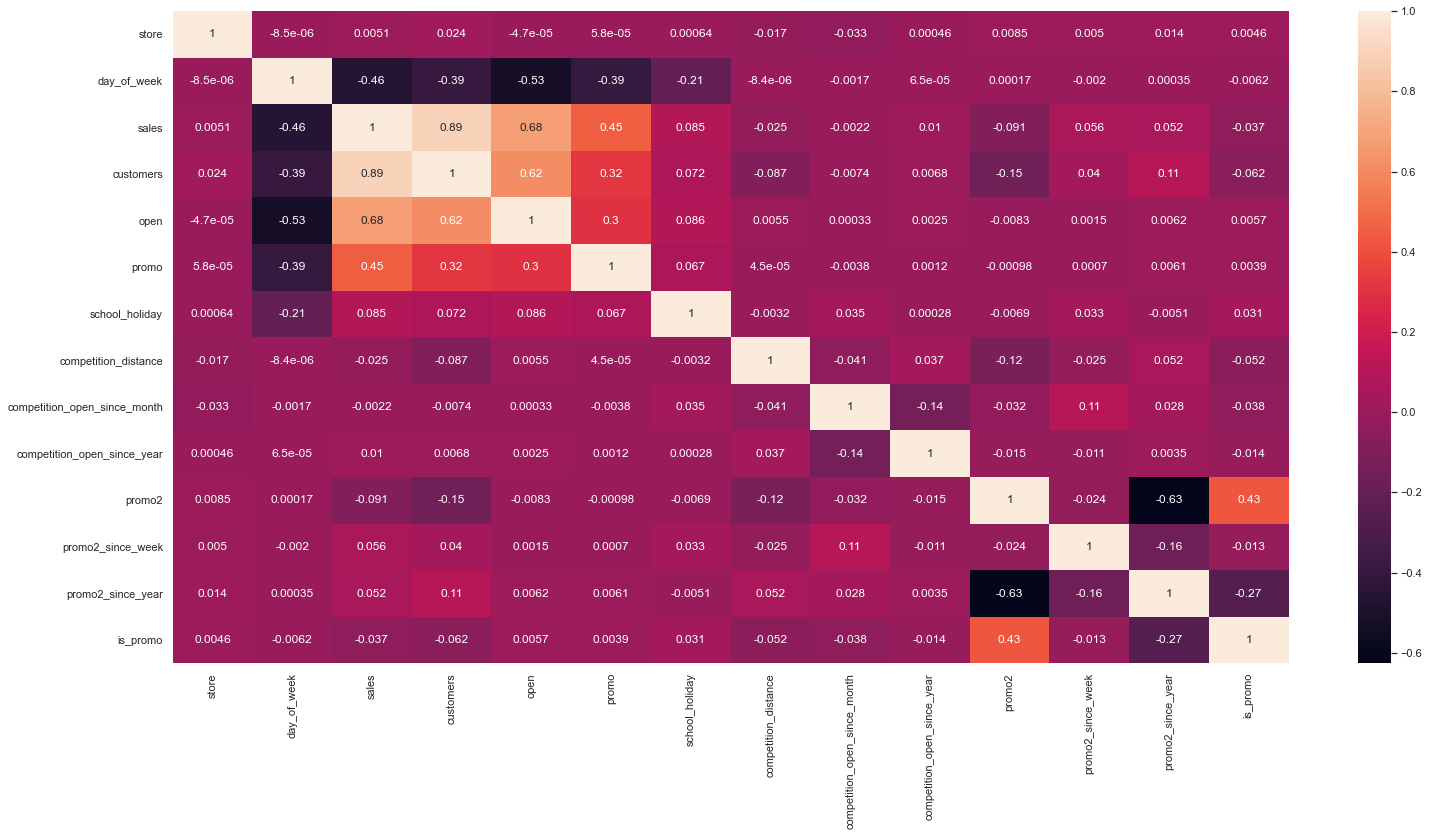

In [243]:
correlation = num_att.corr(method = 'pearson')

sns.heatmap(correlation, annot = True);

### 4.3.2 Categorical Attributes

In [280]:
# only categorical attibutes

a = df4.select_dtypes(include = 'object')

# cramer v

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# dataset for correlation of categorical attibutes

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7, a8, a9]
                 })

d = d.set_index(d.columns)

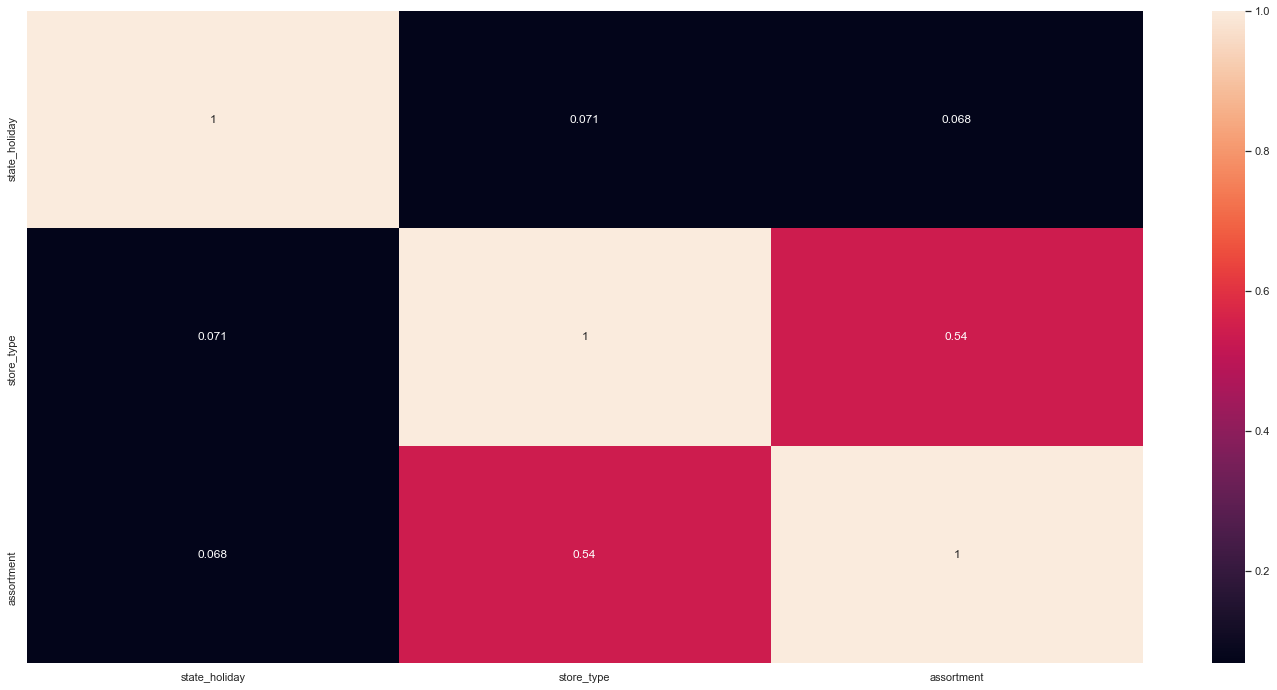

In [281]:
sns.heatmap(d, annot = True);